In [1]:
import os
import tweepy as tw
import pandas as pd
import csv
import pandas as pd
import glob
from nltk.corpus import stopwords
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from sklearn.model_selection import train_test_split
import keras.models
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras import backend as K

In [2]:
def create_data_corpus(path):
  files = glob.glob(path + "/*.csv")
  df_list = []
  
  for file in files:
    df = pd.read_csv(file, index_col=None, header=0)
    df_list.append(df)

  frame = pd.concat(df_list, axis=0, ignore_index=True)
  return frame
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)        
  return input_txt
def clean_tweets(frame, column_name):
  frame = frame.drop_duplicates().reset_index(drop=True) #remove duplicate rows
  frame['Tweet_Clean_Text'] = np.vectorize(remove_pattern)(frame[column_name], "RT @[\w]*:") #remove twitter return handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "@[\w]*") #remove twitter handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "https?://[A-Za-z0-9./]*") #remove URLs
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.str.replace("[^a-zA-Z#]", " ") #remove special characters except for #
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.replace('\s+', ' ', regex=True) #remove extra spaces in between words

  return frame

In [4]:
semeval_frame = create_data_corpus('/content/input') #Use your own path, I have mounted the data from google drive
semeval_frame = clean_tweets(semeval_frame, 'Column3')
semeval_frame

,Column1,Column2,Column3,Tweet_Clean_Text
0,1.051210e+17,negative,I forgot how sad the first episode of the 5th ...,I forgot how sad the first episode of the th s...
1,1.043190e+17,negative,Oct. 2 is almost too far away for me to wait f...,Oct is almost too far away for me to wait for ...
2,1.036420e+17,neutral,(OFF TOPIC) - there is only 3 episodes on the ...,OFF TOPIC there is only episodes on the first...
3,1.005450e+17,neutral,@iheardavoicesay is finally catching up to me ...,is finally catching up to me with #Dexter I m...
4,1.022200e+17,neutral,"I downloaded the first season of #Dexter, gonn...",I downloaded the first season of #Dexter gonna...
...,...,...,...,...
49710,1.031580e+17,positive,RT @MNFootNg It's monday and Monday Night Foot...,RT It s monday and Monday Night Football is on...
49711,1.031570e+17,positive,All I know is the road for that Lomardi start ...,All I know is the road for that Lomardi start ...
49712,1.002590e+17,neutral,"All Blue and White fam, we r meeting at Golden...",All Blue and White fam we r meeting at Golden ...
49713,1.042300e+17,positive,@DariusButler28 Have a great game agaist Tam...,Have a great game agaist Tampa Bay tonight


In [5]:
semeval_frame['Column2'].value_counts()

neutral     22274
positive    19688
negative     7753
Name: Column2, dtype: int64

In [6]:
semeval_frame['Tweet_Clean_Text'] = semeval_frame['Tweet_Clean_Text'].apply(lambda x: x.lower())
semeval_frame

,Column1,Column2,Column3,Tweet_Clean_Text
0,1.051210e+17,negative,I forgot how sad the first episode of the 5th ...,i forgot how sad the first episode of the th s...
1,1.043190e+17,negative,Oct. 2 is almost too far away for me to wait f...,oct is almost too far away for me to wait for ...
2,1.036420e+17,neutral,(OFF TOPIC) - there is only 3 episodes on the ...,off topic there is only episodes on the first...
3,1.005450e+17,neutral,@iheardavoicesay is finally catching up to me ...,is finally catching up to me with #dexter i m...
4,1.022200e+17,neutral,"I downloaded the first season of #Dexter, gonn...",i downloaded the first season of #dexter gonna...
...,...,...,...,...
49710,1.031580e+17,positive,RT @MNFootNg It's monday and Monday Night Foot...,rt it s monday and monday night football is on...
49711,1.031570e+17,positive,All I know is the road for that Lomardi start ...,all i know is the road for that lomardi start ...
49712,1.002590e+17,neutral,"All Blue and White fam, we r meeting at Golden...",all blue and white fam we r meeting at golden ...
49713,1.042300e+17,positive,@DariusButler28 Have a great game agaist Tam...,have a great game agaist tampa bay tonight


In [7]:
semeval_frame["Sentiment_Value"] = semeval_frame["Column2"].map({"neutral": 0, "positive": 1, "negative": 2})
lbl = to_categorical(semeval_frame["Sentiment_Value"], 3)
semeval_frame


,Column1,Column2,Column3,Tweet_Clean_Text,Sentiment_Value
0,1.051210e+17,negative,I forgot how sad the first episode of the 5th ...,i forgot how sad the first episode of the th s...,2
1,1.043190e+17,negative,Oct. 2 is almost too far away for me to wait f...,oct is almost too far away for me to wait for ...,2
2,1.036420e+17,neutral,(OFF TOPIC) - there is only 3 episodes on the ...,off topic there is only episodes on the first...,0
3,1.005450e+17,neutral,@iheardavoicesay is finally catching up to me ...,is finally catching up to me with #dexter i m...,0
4,1.022200e+17,neutral,"I downloaded the first season of #Dexter, gonn...",i downloaded the first season of #dexter gonna...,0
...,...,...,...,...,...
49710,1.031580e+17,positive,RT @MNFootNg It's monday and Monday Night Foot...,rt it s monday and monday night football is on...,1
49711,1.031570e+17,positive,All I know is the road for that Lomardi start ...,all i know is the road for that lomardi start ...,1
49712,1.002590e+17,neutral,"All Blue and White fam, we r meeting at Golden...",all blue and white fam we r meeting at golden ...,0
49713,1.042300e+17,positive,@DariusButler28 Have a great game agaist Tam...,have a great game agaist tampa bay tonight,1


In [8]:
num_features = 2000
tokenizer = Tokenizer(num_words=num_features, split=' ')
tokenizer.fit_on_texts(semeval_frame['Tweet_Clean_Text'].values)
X = tokenizer.texts_to_sequences(semeval_frame['Tweet_Clean_Text'].values)
X = pad_sequences(X, maxlen=200, padding='post')

In [9]:
Y = lbl

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.15, random_state = 10)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=10)

In [10]:

def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    recall_score.__name__ = 'recall'
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    precision_score.__name__ = 'precision'
    return precision


def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_metrics.__name__ = 'f1'
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

metrics = [
           keras.metrics.CategoricalAccuracy(),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics,
           #keras.metrics.TruePositives(name='tp'),
           #keras.metrics.FalsePositives(name='fp'),
           #keras.metrics.TrueNegatives(name='tn'),
           #keras.metrics.FalseNegatives(name='fn'),
]

def fit_model(x_train,y_train):
  output_dims = 200
  lstm_out = 200

  model = keras.Sequential([
      layers.Embedding(input_dim=num_features, output_dim=output_dims, input_length=X.shape[1]),
      layers.SpatialDropout1D(0.2),
      layers.Bidirectional(layers.LSTM(units=lstm_out, dropout=0.2, recurrent_dropout=0.2)),
      layers.Dense(units=3, activation='softmax')
      ])
  model.compile(optimizer='adam',
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=metrics)
  #fit the model
  history = model.fit(x_train, y_train, epochs = 10, batch_size=1000, verbose=2,validation_data=(x_val,y_val))

  return model


In [ ]:
n_members = 5
for i in range(n_members):
	# fit model
	model = fit_model(x_train,y_train)
	# save model
	filename = 'models/model_' + str(i + 1) + '.h5'
	model.save(filename)
	print('>Saved %s' % filename)

Epoch 1/10
36/36 - 977s - loss: 0.9863 - categorical_accuracy: 0.4996 - precision: 0.6212 - recall: 0.1603 - f1_metrics: 0.2141 - val_loss: 0.8908 - val_categorical_accuracy: 0.5850 - val_precision: 0.6411 - val_recall: 0.4540 - val_f1_metrics: 0.5298
Epoch 2/10


In [ ]:
# stacked generalization with neural net meta model on blobs dataset
from sklearn.metrics import accuracy_score
from keras.models import load_model
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
from numpy import argmax

# load models from file
def load_all_models(n_models):
	all_models = list()
	for i in range(n_models):
		# define filename for this ensemble
		filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
		model = load_model(filename,custom_objects={'f1':f1_metrics,'precision':precision_score,'recall':recall_score})
		# add to list of members
		all_models.append(model)
		print('>loaded %s' % filename)
	return all_models

# define stacked model from multiple member input models
def define_stacked_model(members):
	# update all layers in all models to not be trainable
	for i in range(len(members)):
		model = members[i]
		for layer in model.layers:
			# make not trainable
			layer.trainable = False
			# rename to avoid 'unique layer name' issue
			layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
	# define multi-headed input
	ensemble_visible = [model.input for model in members]
	# concatenate merge output from each model
	ensemble_outputs = [model.output for model in members]
	merge = concatenate(ensemble_outputs)
	hidden = Dense(10, activation='relu')(merge)
	output = Dense(3, activation='softmax')(hidden)
	model = Model(inputs=ensemble_visible, outputs=output)
	# plot graph of ensemble
	plot_model(model, show_shapes=True, to_file='model_graph.png')
	# compile
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# fit a stacked model
def fit_stacked_model(model, inputX, inputy):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# encode output data
	#inputy_enc = to_categorical(inputy)
	# fit model
	model.fit(X, inputy, epochs=10, verbose=2)

# make a prediction with a stacked model
def predict_stacked_model(model, inputX):
	# prepare input data
	X = [inputX for _ in range(len(model.input))]
	# make prediction
	return model.predict(X, verbose=0)


# load all models
n_members = 5
members = load_all_models(n_members)
print('Loaded %d models' % len(members))
# define ensemble model
stacked_model = define_stacked_model(members)
# fit stacked model on test dataset
fit_stacked_model(stacked_model, x_train,y_train)
# make predictions and evaluate

yhat = predict_stacked_model(stacked_model, x_train)
'''
for i in range(49462):
  emo=np.where(yhat[i]==max(yhat[i]))[0][0]
  yhat[i][emo]=1
  yhat[i][(emo+1)%3]=0
  yhat[i][(emo+2)%3]=0
yhat = np.array(yhat, dtype='int64')
acc = accuracy_score(y_train, yhat)
print('Stacked Test Accuracy: %.3f' % acc)
'''


>loaded models/model_1.h5
>loaded models/model_2.h5
Loaded 2 models
Epoch 1/10
1123/1123 - 1955s - loss: 0.7105 - accuracy: 0.6909
Epoch 2/10
1123/1123 - 1933s - loss: 0.6434 - accuracy: 0.7227
Epoch 3/10
1123/1123 - 1939s - loss: 0.6409 - accuracy: 0.7219
Epoch 4/10
1123/1123 - 1925s - loss: 0.6409 - accuracy: 0.7224
Epoch 5/10


In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'categorical_accuracy', 'precision', 'recall', 'f1_metrics']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()

KeyError: ignored

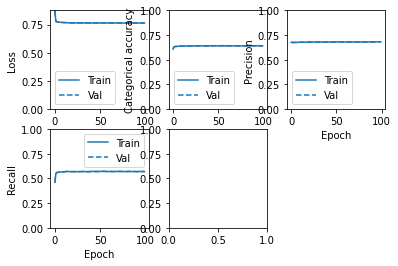

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(history)